In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src"))  # Adds 'src' to the module search path

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plot import plot_bar_horizontal,plot_bar_vertical,vertical_boxplot
import numpy as np
import itertools
from scipy.stats import wasserstein_distance
np.random.seed(42)
HOME_DIR = "../"

# Dataset properties

## Global information

In [7]:
df = pd.read_parquet(f"{HOME_DIR}raw_data/80_tasks.parquet",engine="pyarrow")

In [8]:
df[['task_id','filename','dataset','sequence']].nunique()

task_id         80
filename      1329
dataset         29
sequence    691476
dtype: int64

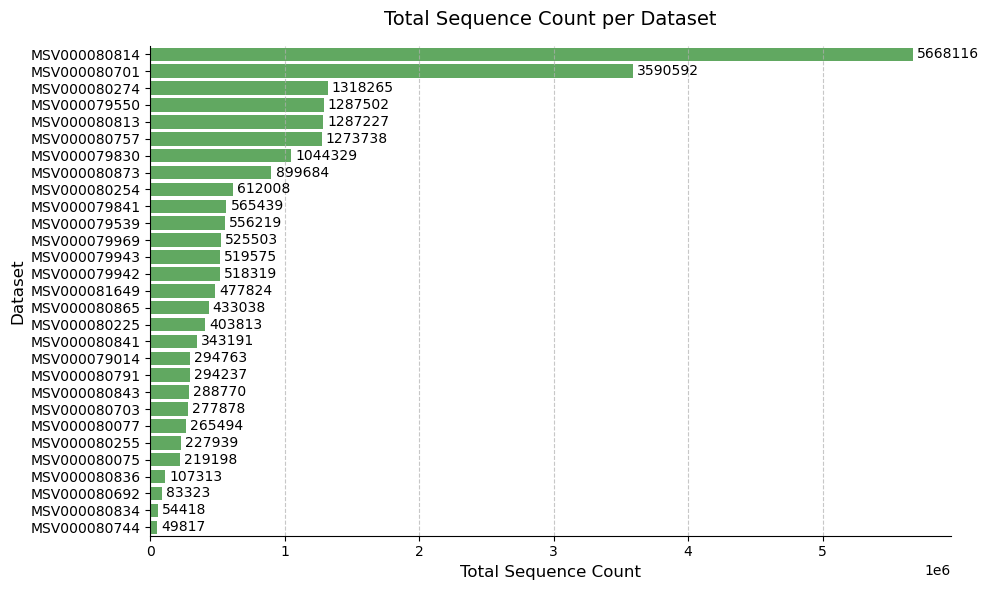

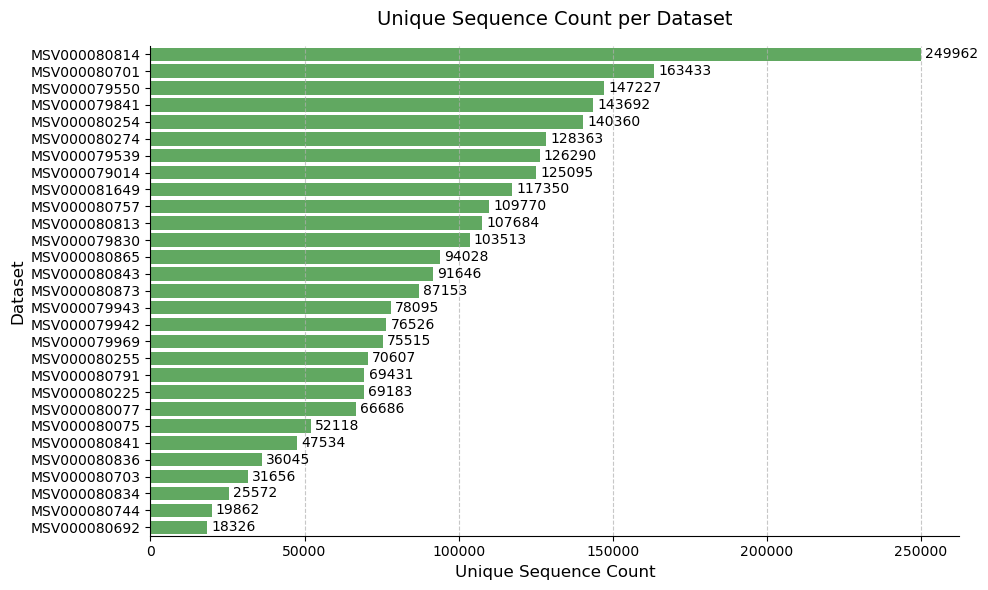

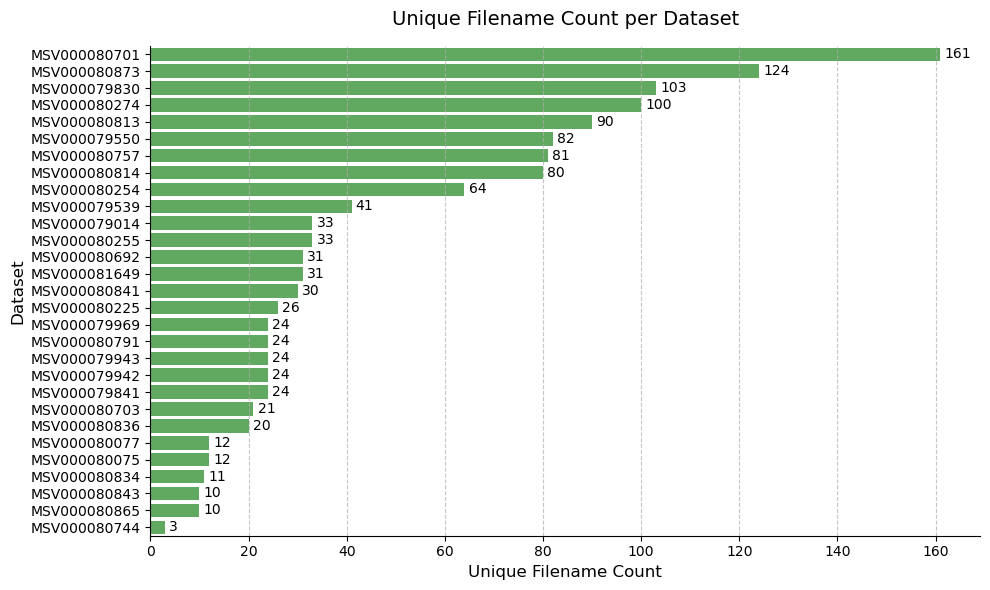

In [9]:
sequences_dataset = df.groupby('dataset')['sequence'].count()
plot_bar_horizontal(
    sequences_dataset,
    xlabel="Total Sequence Count",
    ylabel="Dataset",
    title="Total Sequence Count per Dataset"
)
# 2. Unique sequence counts
unique_sequences_dataset = df.groupby('dataset')['sequence'].nunique()
plot_bar_horizontal(
    unique_sequences_dataset,
    xlabel="Unique Sequence Count",
    ylabel="Dataset",
    title="Unique Sequence Count per Dataset"
)
unique_filenames_dataset = df.groupby('dataset')['filename'].nunique()
plot_bar_horizontal(
    unique_filenames_dataset,
    xlabel="Unique Filename Count",
    ylabel="Dataset",
    title="Unique Filename Count per Dataset"
)

## Peptide distribution

In [9]:
df = pd.read_parquet(f"{HOME_DIR}raw_data/80_tasks.parquet",engine="pyarrow")

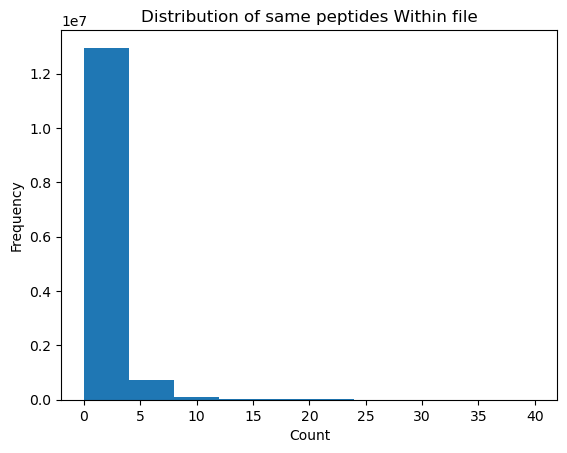

In [10]:
overlap_in_file = df.groupby(['sequence','filename'])['filename'].count()
overlap_in_file.plot.hist(range=(0, 40))
plt.title("Distribution of same peptides Within file")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

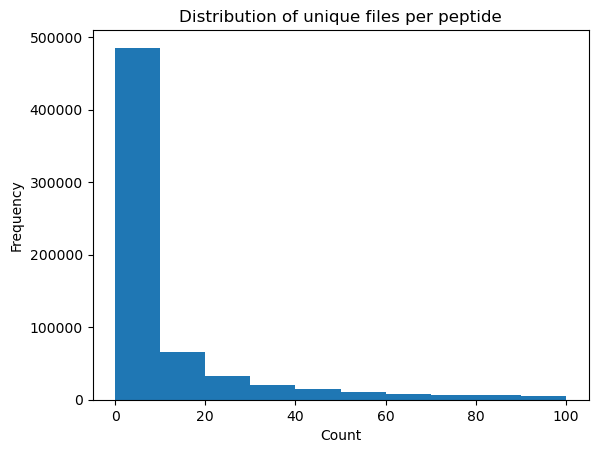

In [11]:
overlap_across_file = df.groupby('sequence')['filename'].nunique()
overlap_across_file.plot.hist(range=(0, 100))
plt.title("Distribution of unique files per peptide")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

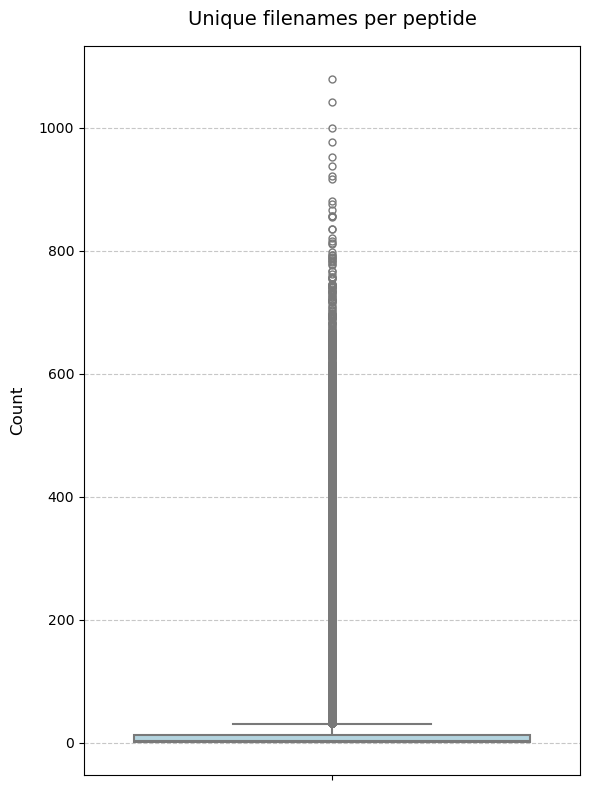

In [12]:
vertical_boxplot(overlap_across_file,"Count","Unique filenames per peptide")

# Retention time analysis

In [122]:
df = pd.read_parquet(f"{HOME_DIR}raw_data/80_tasks.parquet",engine="pyarrow")

## MAD

In [123]:
def mean_absolute_deviation(series,threshhold):
    if len(series)<threshhold:
        return None
    return (series - series.mean()).abs().mean()

In [124]:
mean_same_msrun = df.groupby(['sequence', 'filename'])['iRT'].apply(lambda x: mean_absolute_deviation(x, 2)).dropna().mean()
mean_across_dataset = df.groupby(['sequence', 'dataset'])['iRT'].apply(lambda x: mean_absolute_deviation(x, 2)).dropna().mean()
mean_across_all = df.groupby(['sequence'])['iRT'].apply(lambda x: mean_absolute_deviation(x, 2)).dropna().mean()

C:\Users\lambe\Documents\School\thesis\MTL-peptide-property-prediction_temp\src\plot.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


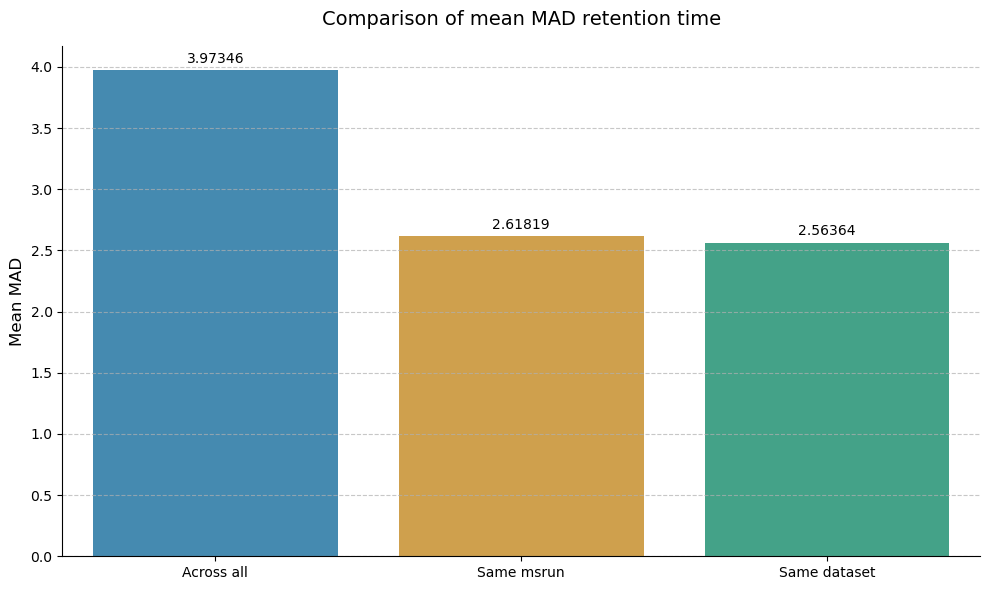

In [125]:
comparison = pd.Series(
    [mean_same_msrun,mean_across_dataset,mean_across_all],
    index=["Same msrun","Same dataset","Across all"]
)
# Call the plotting function with the Series
plot_bar_vertical(
    data_series=comparison,
    title="Comparison of mean MAD retention time",
    xlabel="",
    ylabel="Mean MAD",
    figsize=(10, 6)
)

## KDE plots

In [213]:
np.random.seed(42)
HOME_DIR = "../"
df = pd.read_parquet(f"{HOME_DIR}raw_data/80_tasks.parquet",engine="pyarrow")

In [214]:
def plot_kde_grouped(df, threshold, legend=None):
    grouped = df.groupby('sequence')
    for sequence, seq_group in grouped:
        plt.figure(figsize=(8, 6))
        # Group again within each sequence by filename to get iRT values
        for filename, values in seq_group.groupby('filename')['iRT']:
            values = list(values)  # Convert Series to list
            if len(values) >= threshold:
                label = f"{filename} (n={len(values)})"
                sns.kdeplot(values, label=label, fill=False)

        plt.xlabel("Retention Time")
        plt.ylabel("Density")
        if legend:
            plt.legend(title="Filename", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(f"KDE Plot for Sequence: {sequence}")
        plt.show()

In [215]:
overlap_across_msrun = df.groupby('sequence')['filename'].nunique()
overlap_in_msrun = df.groupby(['sequence','filename'])['filename'].count()

In [223]:
interesting_peptides_across = overlap_across_msrun[(overlap_across_msrun > 10) & (overlap_across_msrun < 30)].index
# Filter rows where the value is > 5
filtered = overlap_in_msrun[overlap_in_msrun > 5]

# Group by sequence and find sequences appearing more than 5 times
sequence_counts = filtered.groupby('sequence').count()
interesting_peptides_inside = sequence_counts[sequence_counts > 5].index
interesting_peptides = interesting_peptides_across.intersection(interesting_peptides_inside)[:10]

In [227]:
df_sequence = df[df['sequence'].isin(interesting_peptides)]

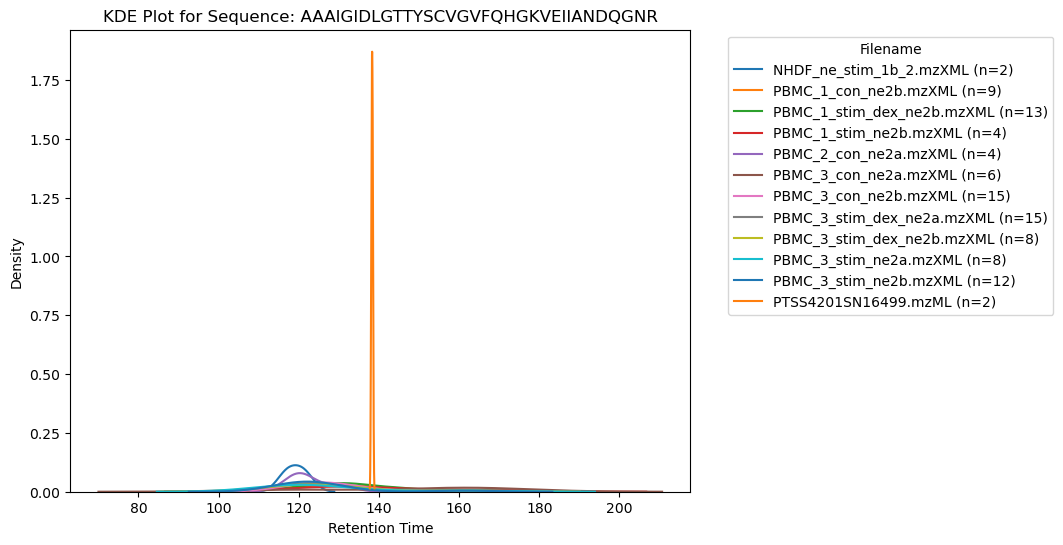

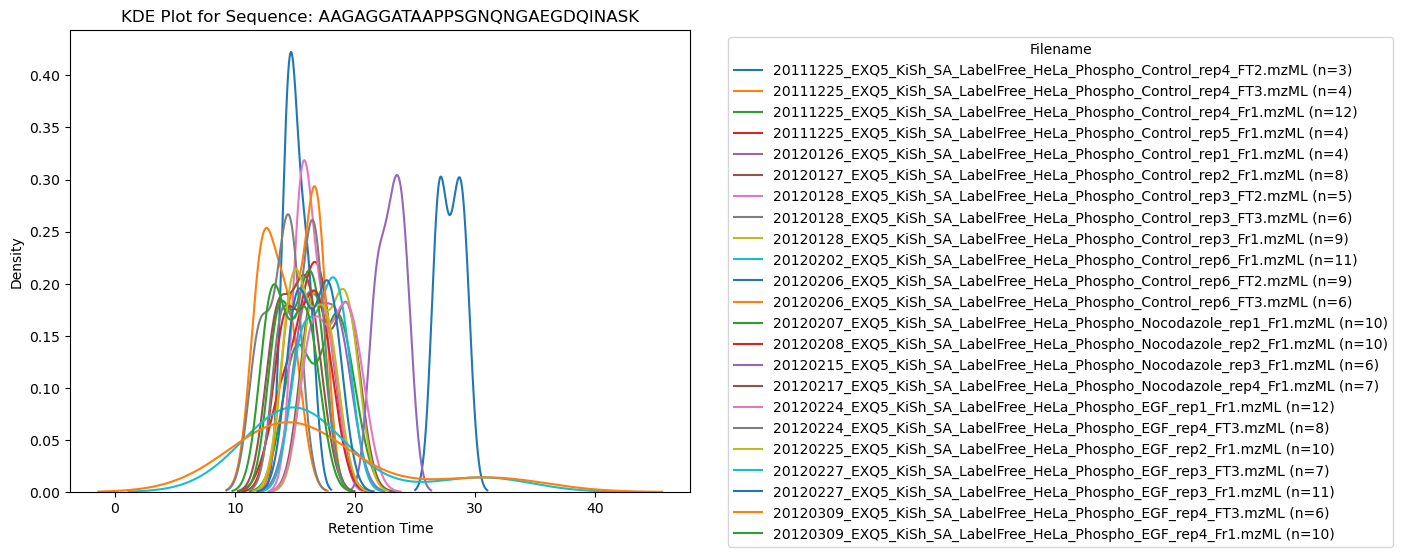

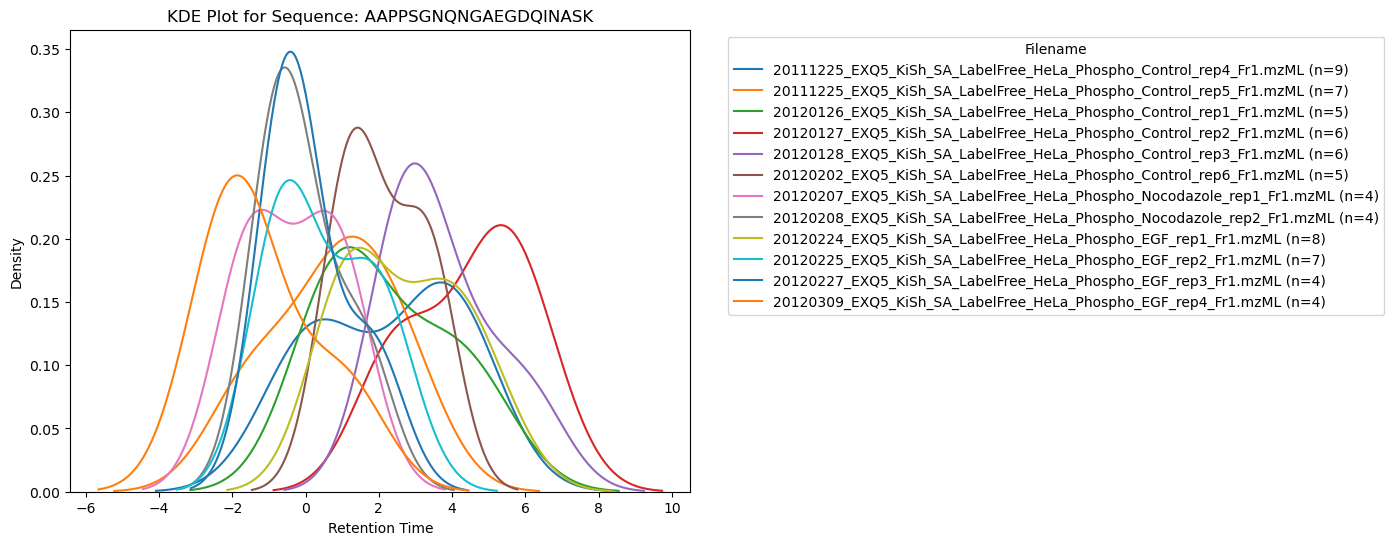

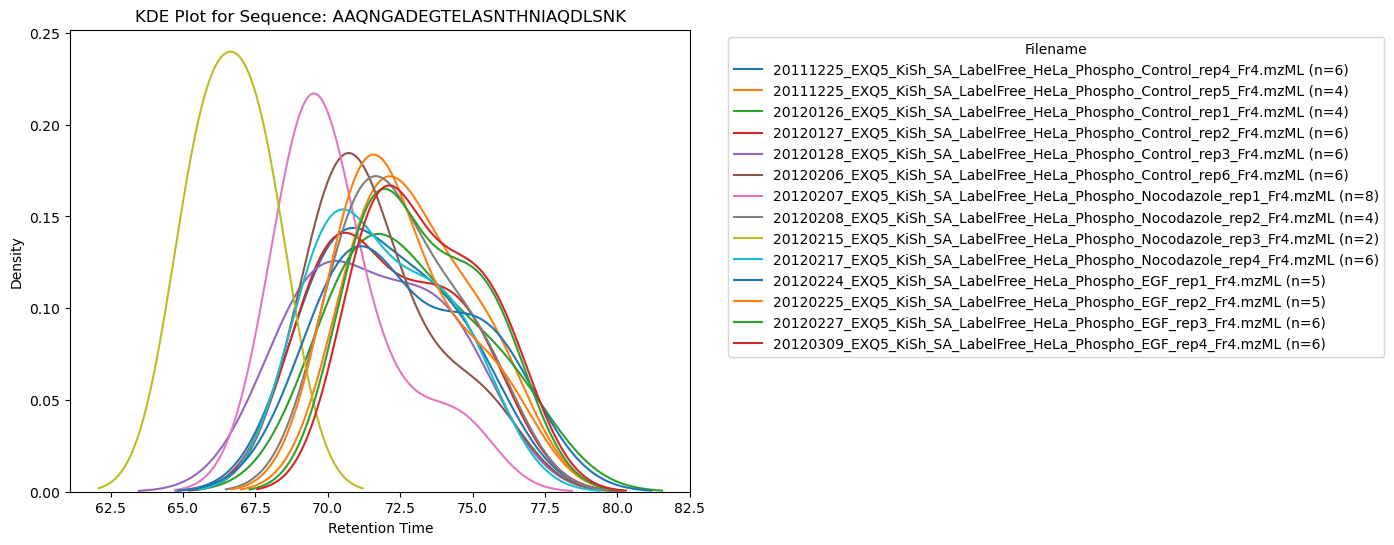

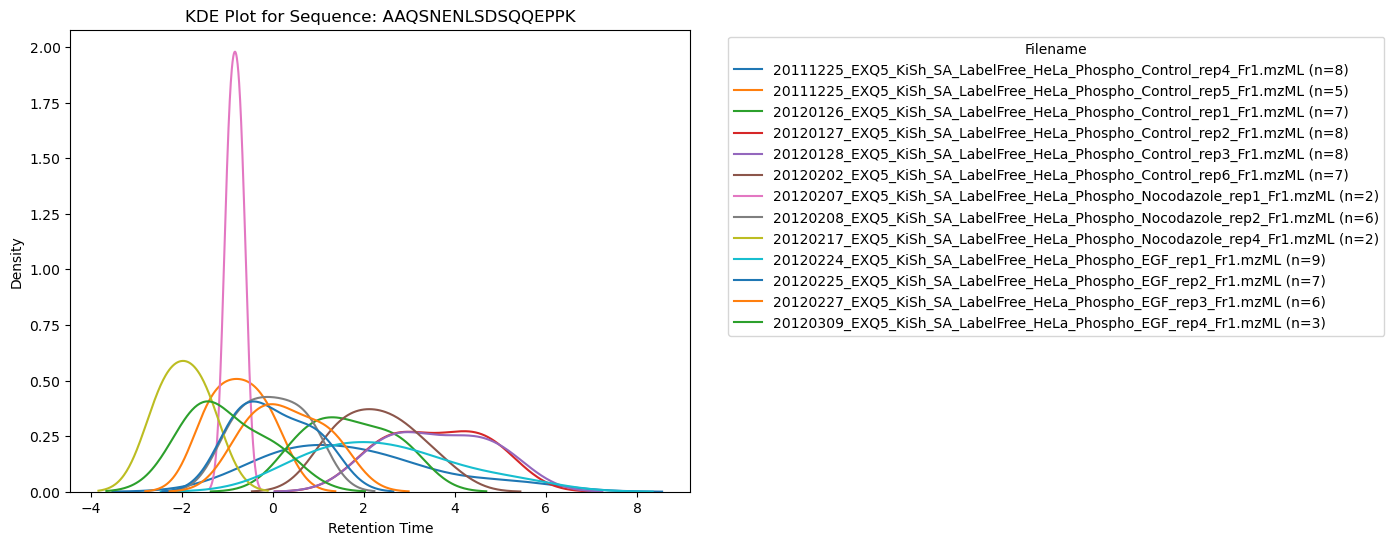

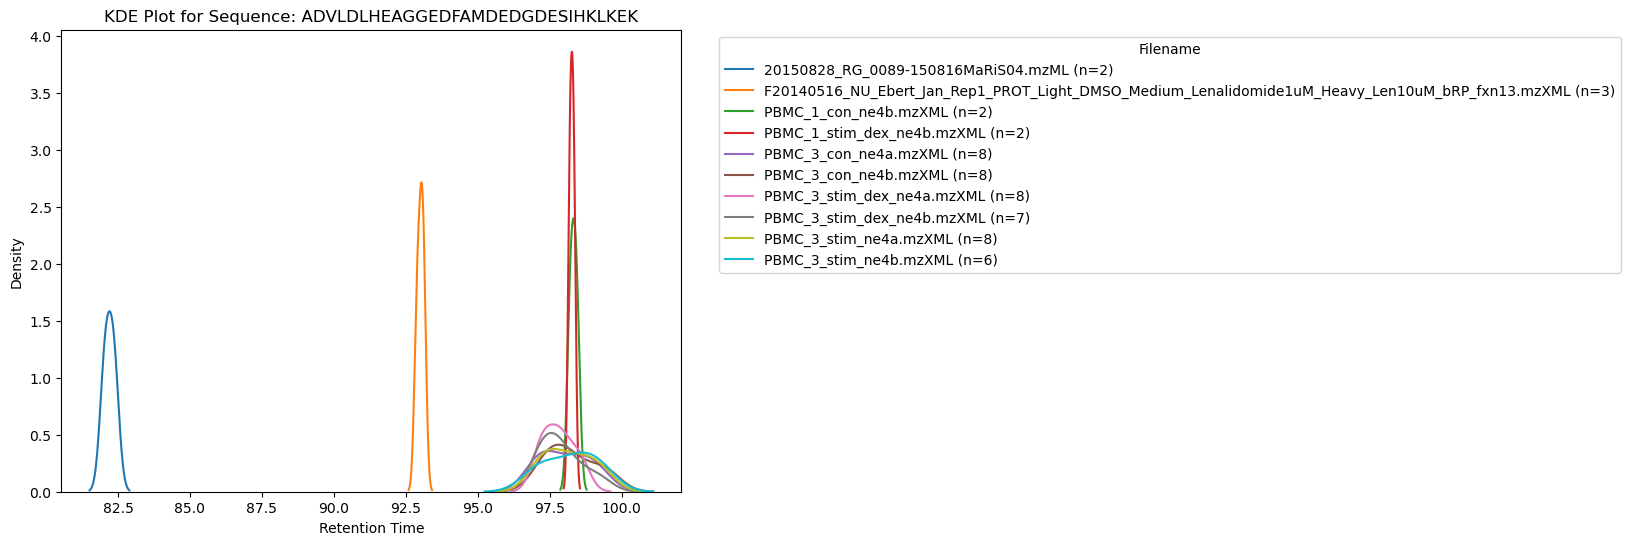

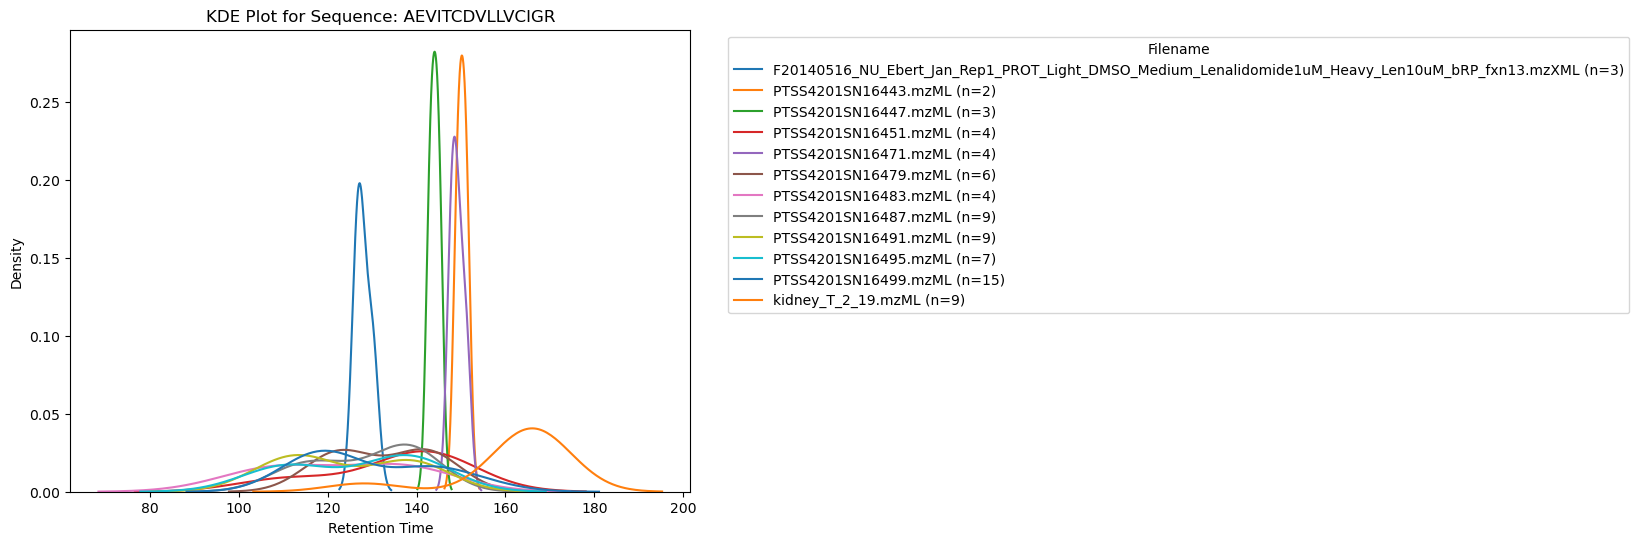

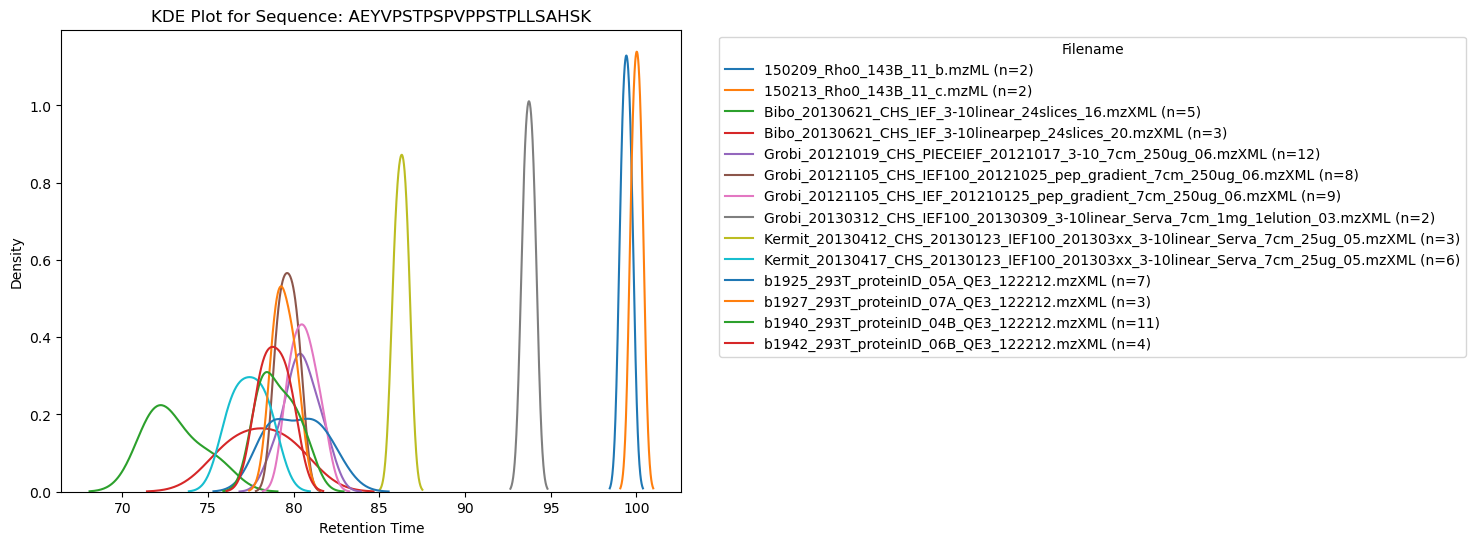

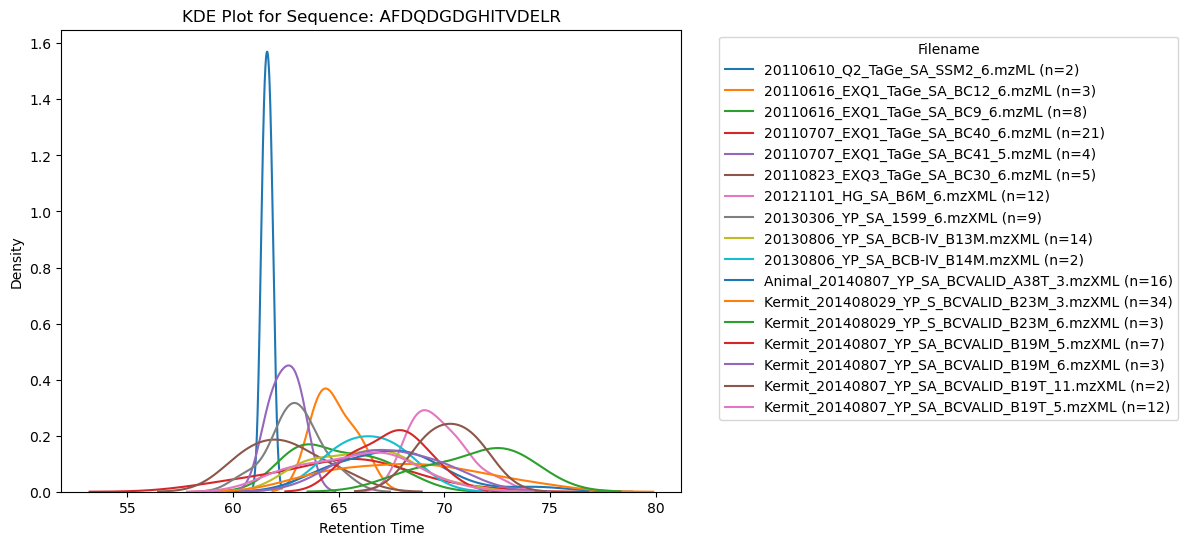

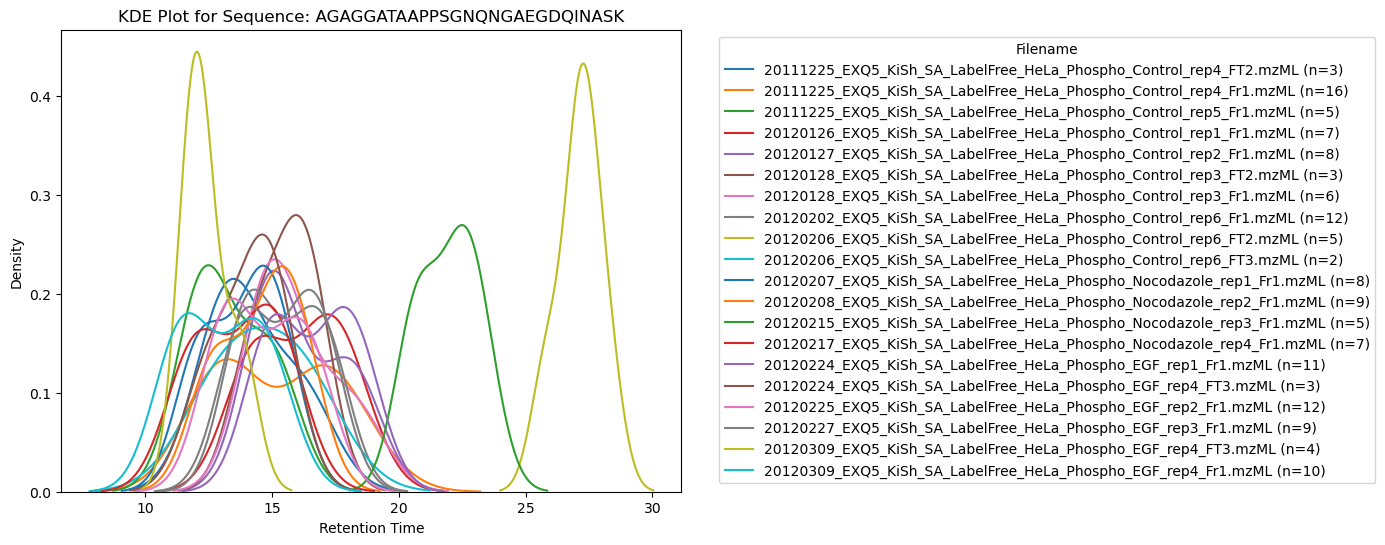

In [231]:
plot_kde_grouped(df_sequence,2,legend=True)

## Wasserstein distance

In [19]:
df = pd.read_parquet(f"{HOME_DIR}raw_data/80_tasks.parquet",engine="pyarrow")

In [20]:
def compute_mean_wasserstein_distance(df,min_files):
    grouped = df.groupby('sequence')
    mean_distances = {}

    for sequence, group in grouped:
        distributions = group.groupby('filename')['iRT'].apply(list)
        distributions_dict = {k: v for k, v in distributions.to_dict().items() if len(v) >= min_files}  # Exclude single-value distributions
        filenames = list(distributions_dict.keys())

        distances = [
            wasserstein_distance(distributions_dict[file1], distributions_dict[file2])
            for file1, file2 in itertools.combinations(filenames, 2)
        ]

        if distances:
            mean_distances[sequence] = sum(distances) / len(distances)

    return mean_distances

In [ ]:
mean_wasserstein = compute_mean_wasserstein_distance(df,1)

In [ ]:
# Extract values
x_values = np.array(list(mean_wasserstein.values()))

# Create KDE plot
plt.figure(figsize=(8, 5))
sns.kdeplot(x_values, fill=True, color="skyblue")
plt.xlim(0, 100)

# Labels and title
plt.xlabel("Wasserstein  distance")
plt.ylabel("Intensity")
plt.title("KDE Plot of mean Wasserstein  distance")

# Show the plot
plt.show()

# Data split analysis

In [11]:
DATA = "../data/"

In [25]:
train_df0 = pd.read_parquet(f"{DATA}high_variety/all.parquet",engine="pyarrow")
train_df1 = pd.read_parquet(f"{DATA}low_variety/all.parquet",engine="pyarrow")
val_df = pd.read_parquet(f"{DATA}val.parquet",engine="pyarrow")
test_df = pd.read_parquet(f"{DATA}test.parquet",engine="pyarrow")
train_df = pd.read_parquet(f"{DATA}train.parquet",engine="pyarrow")

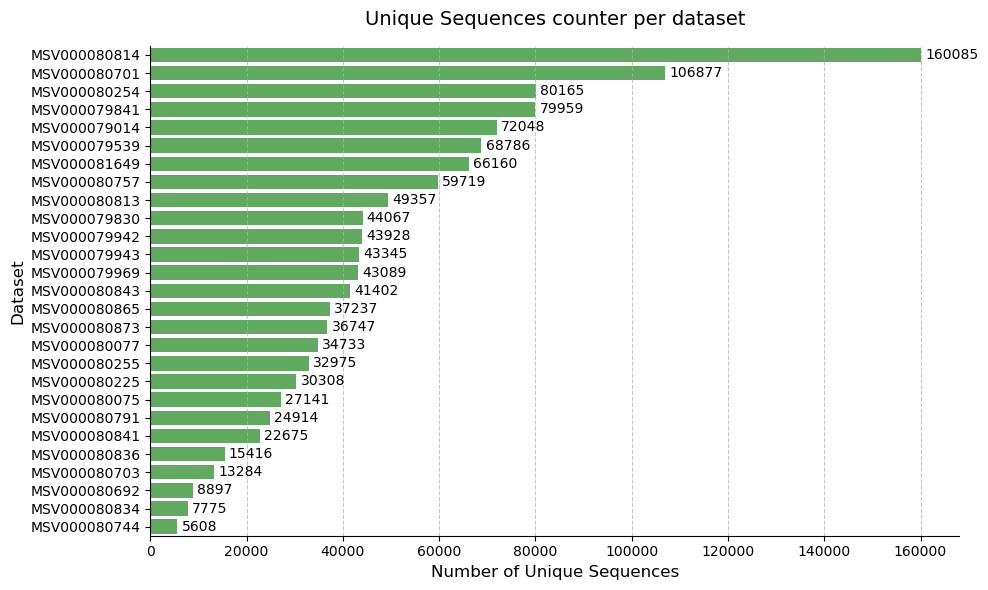

In [33]:
unique_sequences = train_df.groupby("dataset")["sequence"].nunique()
plot_bar_horizontal(
    data_series=unique_sequences,
    title="Unique Sequences counter per dataset",
    xlabel="Number of Unique Sequences",
    ylabel="Dataset",
    figsize=(10, 6)
)

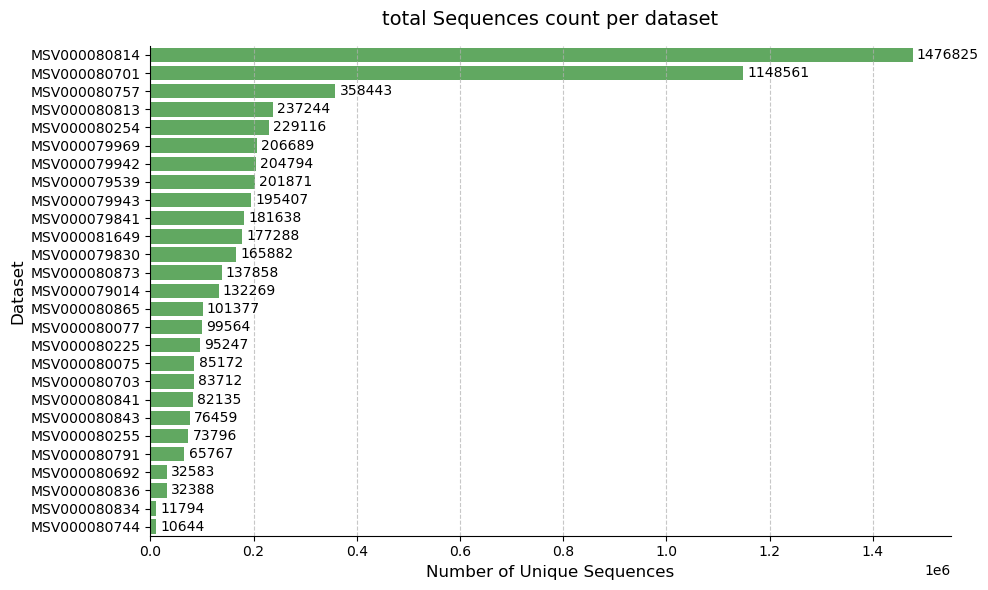

In [37]:
total_sequences = train_df.groupby("dataset")["sequence"].count()
plot_bar_horizontal(
    data_series=total_sequences,
    title="total Sequences count per dataset",
    xlabel="Number of Unique Sequences",
    ylabel="Dataset",
    figsize=(10, 6)
)

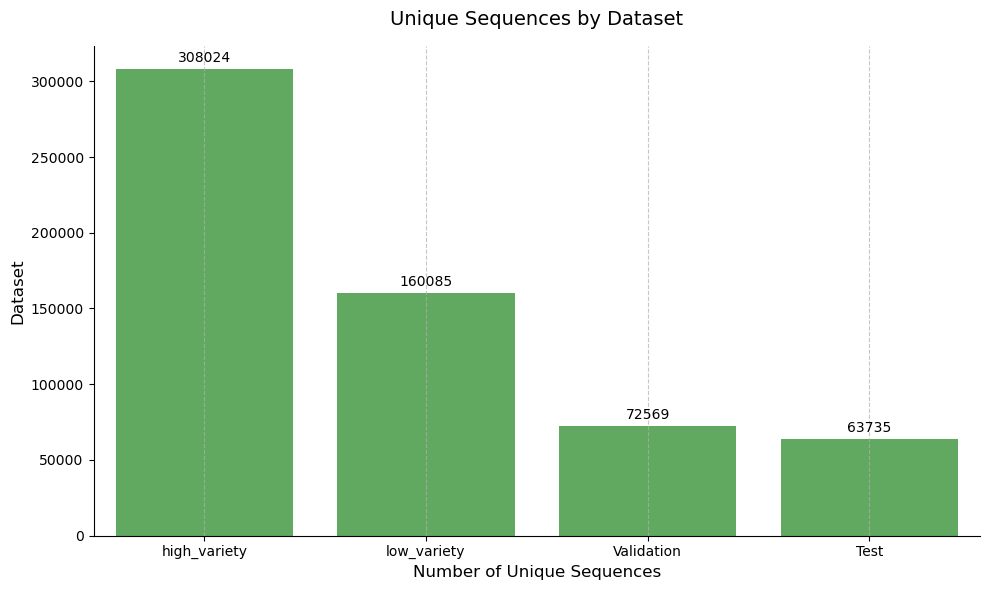

In [23]:
unique_df0_peptides = train_df0["modified_sequence"].nunique()
unique_df1_peptides = train_df1["modified_sequence"].nunique()
unique_val_df_petides = val_df["modified_sequence"].nunique()
unique_test_df_petides = test_df["modified_sequence"].nunique()
# Calculate the lengths of unique peptides for each dataset
unique_counts = pd.Series({
    "high_variety": unique_df0_peptides,
    "low_variety": unique_df1_peptides,
    "Validation": unique_val_df_petides,
    "Test": unique_test_df_petides
})

# Call the plotting function with the Series
plot_bar_vertical(
    data_series=unique_counts,
    title="Unique Sequences by Dataset",
    xlabel="Number of Unique Sequences",
    ylabel="Dataset",
    figsize=(10, 6)
)

## Analysis Test set